# Test MH harmonic

In [76]:
import os, sys, time
import argparse
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.random as random
import toml
import numpyro
from functools import partial
import micmac
from micmac import *
from fgbuster.observation_helpers import *

from jax import config
current_path = os.path.abspath('')
sys.path.append(current_path)
sys.path.append(os.path.dirname(os.path.dirname(current_path))+'/tutorials/')

config.update("jax_enable_x64", True)

In [2]:
path_home_test_playground = os.path.dirname(current_path) + '/'

In [3]:
working_directory_path = os.path.abspath('') + '/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'main_params/'
directory_additional_params = working_directory_path + 'additional_params/'

# path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'


In [4]:
num_jobs = 1
file_ver = 'corr_fullsky_LB_d0s0_nside0_v109_v1a_{}_{}'
path_additional_params = directory_additional_params + 'add_corr_fullsky_LB_d0s0_nside0_v1a.toml'
## 

In [40]:
# save_chains = False
save_chains = True

In [6]:
# reduction_Fisher = 10
reduction_Fisher = 100

In [7]:
with open(path_additional_params) as f:
    dictionary_additional_parameters = toml.load(f)
f.close()

reduction_noise = dictionary_additional_parameters['reduction_noise']
fgs_model = dictionary_additional_parameters['fgs_model']
use_mask = dictionary_additional_parameters['use_mask']
use_nhits = dictionary_additional_parameters['use_nhits']
name_toml = dictionary_additional_parameters['name_toml']
seed_realization_input = dictionary_additional_parameters['seed_realization_input']

print("Using toml file: ", name_toml)

Using toml file:  corr_fullsky_LB_v1a.toml


In [8]:
path_toml_file = directory_toml_file + name_toml

In [9]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)


No spatial variability case



>>> Tree of spv config as passed by the User:
root
  nside_spv
    default: [0]
    f0
      default: None
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
      b4
        default: None
      b5
        default: None
      b6
        default: None
      b7
        default: None
      b8
        default: None
      b9
        default: None
      b10
        default: None
      b11
        default: None
      b12
        default: None
    f1
      default: None
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
      b4
        default: None
      b5
        default: None
      b6
        default: None
      b7
        default: None
      b8
        default: None
      b9
        default: None
      b10
        default: None
      b11
        default: None
      b12
        default: None

>>> Tree of spv config after filling the missing val

In [10]:
fgs_model_ = 'd0s0'
instr_name = MICMAC_sampler_obj.instrument_name #'SO_SAT'

path_Fisher = path_home_test_playground + f'Fisher_matrix_{MICMAC_sampler_obj.instrument_name}_EB_model_{fgs_model_}_noise_True_seed_42_lmin2_lmax128_v2.txt'
try :
    Fisher_matrix = np.loadtxt(path_Fisher)
    print("Read from: ", path_Fisher)
except:
    print("Fisher matrix not found !", flush=True)
    Fisher_matrix = np.loadtxt(path_home_test_playground + f'Fisher_matrix_{MICMAC_sampler_obj.instrument_name}_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt')


Read from:  /Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Fisher_matrix_LiteBIRD_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128_v2.txt


In [11]:
directory_mask = "/Users/mag/Documents/PHD1Y/Masks/"
path_mask = directory_mask + "mask_SAT_apodized.fits"

if use_mask:
    apod_mask = hp.ud_grade(hp.read_map(path_mask),nside_out=MICMAC_sampler_obj.nside)

    template_mask = np.copy(apod_mask)
    if use_nhits:
        template_mask[template_mask<relative_treshold] = 0
        inverse_nhits_mask = np.copy(template_mask)
        inverse_nhits_mask[template_mask>0] = 1/template_mask[template_mask>0]

        mask = np.copy(template_mask)
        mask[template_mask>0] = 1
        mask[template_mask==0] = 0
    else:
        mask = np.copy(apod_mask)
        mask[apod_mask>0] = 1
        mask[apod_mask==0] = 0
        template_mask = mask
else:
    template_mask = np.ones_like(MICMAC_sampler_obj.mask)

In [12]:
# get instrument from public database
instrument = get_instrument(instr_name)
depth_p_array = np.array(instrument['depth_p'])/dictionary_additional_parameters['reduction_noise']

In [13]:
covariance_B_f_to_use = np.linalg.inv(Fisher_matrix)[:-1, :-1]/reduction_Fisher
# covariance_B_f_to_use = np.linalg.inv(Fisher_matrix)[:-1, :-1]/100

MICMAC_Harm_obj = create_Harmonic_MICMAC_sampler_from_MICMAC_sampler_obj(MICMAC_sampler_obj, depth_p_array,
                                                    covariance_B_f=covariance_B_f_to_use)

MICMAC_Harm_obj.step_size_r = np.sqrt(np.linalg.inv(Fisher_matrix)[-1, -1])

No spatial variability case


In [14]:
NSIDE = MICMAC_Harm_obj.nside

noise_seed = MICMAC_Harm_obj.seed
# instr_name = MICMAC_Harm_obj.instrument_name

# # get instrument from public database
# instrument = get_instrument(instr_name)

# get input freq maps
np.random.seed(noise_seed)

freq_maps_fgs = get_observation(instrument, fgs_model, nside=NSIDE, noise=True)[:, 1:, :]   # keep only Q and U

_, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_Harm_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]

indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_Harm_obj.nstokes]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Calculating spectra from CAMB !
Calculating spectra from CAMB !


## Retrieving input map

In [15]:
initial_freq_maps = []
input_cmb_maps = []
MICMAC_all_r_samples = []
MICMAC_all_params_mixing_matrix_samples = []

for job in range(num_jobs):
    initial_freq_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_initial_data.npy'
    initial_freq_maps.append(np.load(initial_freq_maps_path))

    initial_cmb_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_initial_cmb_data.npy'
    input_cmb_maps.append(np.load(initial_cmb_maps_path))

    if MICMAC_sampler_obj.sample_r_Metropolis:
        all_r_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_r_samples.npy'
        MICMAC_all_r_samples.append(np.load(all_r_samples_path))

    all_params_mixing_matrix_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_params_mixing_matrix_samples.npy'
    MICMAC_all_params_mixing_matrix_samples.append(np.load(all_params_mixing_matrix_samples_path))

initial_freq_maps = np.array(initial_freq_maps)
input_cmb_maps = np.array(input_cmb_maps)
if MICMAC_sampler_obj.sample_r_Metropolis:
    MICMAC_all_r_samples = np.array(MICMAC_all_r_samples)
MICMAC_all_params_mixing_matrix_samples = np.array(MICMAC_all_params_mixing_matrix_samples)

In [16]:
f_sky = np.sum(template_mask)/len(template_mask)

input_freq_maps = initial_freq_maps[0]*template_mask/np.sqrt(f_sky)

In [17]:
for i in range(initial_freq_maps.shape[0]):
    print(initial_freq_maps[0][initial_freq_maps[i]-initial_freq_maps[0]!=0])

[]


In [18]:
# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_Harm_obj.n_components, pos_special_freqs=MICMAC_Harm_obj.pos_special_freqs, spv_nodes_b=MICMAC_Harm_obj.spv_nodes_b)

init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_Harm_obj.n_components, nside=MICMAC_Harm_obj.nside, spv_nodes_b=MICMAC_Harm_obj.spv_nodes_b, params=init_params, pos_special_freqs=MICMAC_Harm_obj.pos_special_freqs)
mixing_matrix_sampled = mixing_matrix_obj.get_B()

len_pos_special_freqs = len(mixing_matrix_obj.pos_special_freqs)


In [19]:
theoretical_r0_total = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)
theoretical_r1_tensor = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)

c_ell_approx = np.zeros((3,MICMAC_Harm_obj.lmax+1))
c_ell_approx[0,MICMAC_Harm_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_Harm_obj.lmin:] = theoretical_r0_total[1,:]

red_cov_approx_matrix = get_reduced_matrix_from_c_ell_jax(c_ell_approx)[MICMAC_Harm_obj.lmin:]

In [20]:
final_values_params_mixing_matrix = MICMAC_all_params_mixing_matrix_samples.mean(axis=(0,1)).ravel(order='F')
final_values_r = MICMAC_all_r_samples.mean()

## Starting MH

In [21]:
dimension_free_param_B_f = 2*(MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs)

In [22]:
first_guess = final_values_params_mixing_matrix.ravel(order='F')
first_guess_r = final_values_r

# first_guess = np.abs(final_values_params_mixing_matrix.ravel(order='F') + np.random.uniform(-10,10)*diag_step_size[:dimension_free_param_B_f])
# first_guess_r = np.abs(final_values_r + np.random.uniform(-10,10)*diag_step_size[dimension_free_param_B_f])

# first_guess = np.abs(final_values_params_mixing_matrix.ravel(order='F') + np.random.uniform(-10,10)*np.diag(np.sqrt(covariance_B_f_to_use))[:dimension_free_param_B_f])
# first_guess_r = np.abs(final_values_r + np.random.uniform(-10,10)*MICMAC_Harm_obj.step_size_r)

In [23]:
MICMAC_Harm_obj.number_iterations_sampling = 20000
# MICMAC_Harm_obj.number_iterations_sampling = 10000
# MICMAC_Harm_obj.number_iterations_sampling = 5000
# MICMAC_Harm_obj.number_iterations_sampling = 2000
# MICMAC_Harm_obj.number_iterations_sampling = 1000
# MICMAC_Harm_obj.number_iterations_sampling = 500

In [24]:
MICMAC_Harm_obj.perform_harmonic_MH(input_freq_maps, c_ell_approx, first_guess, initial_guess_r=first_guess_r,
                                    covariance_B_f_r=None, theoretical_r0_total=theoretical_r0_total, theoretical_r1_tensor=theoretical_r1_tensor)

Disabling chex !!!
Covariance B_f, r: [[ 1.91069955e-09  3.96564674e-10  3.30249907e-10  2.80597101e-10
   2.48217938e-10  2.28131170e-10  2.07900314e-10  1.95622901e-10
   1.86545048e-10  1.79410386e-10  1.69982689e-10  1.54770499e-10
   1.16102467e-10 -2.29269361e-11 -4.01643911e-12 -3.08486605e-12
  -2.38828565e-12 -1.93525029e-12 -1.65554797e-12 -1.37704589e-12
  -1.21320451e-12 -1.10077702e-12 -1.02564881e-12 -9.50864132e-13
  -8.59209342e-13 -6.51453652e-13  0.00000000e+00]
 [ 3.96564674e-10  8.88954555e-10  3.10688666e-10  2.91074373e-10
   2.78147162e-10  2.69976441e-10  2.61386165e-10  2.55590849e-10
   2.50324738e-10  2.44696316e-10  2.34502389e-10  2.14787833e-10
   1.61836069e-10 -4.01580659e-12 -9.69340103e-12 -2.40681973e-12
  -2.04216675e-12 -1.80444437e-12 -1.65705045e-12 -1.50878963e-12
  -1.41912234e-12 -1.35334038e-12 -1.30242538e-12 -1.23660080e-12
  -1.13211154e-12 -8.68006869e-13  0.00000000e+00]
 [ 3.30249907e-10  3.10688666e-10  6.48150158e-10  2.95481128e-10
  

sample: 100%|██████████| 20000/20000 [1:14:18<00:00,  4.49it/s]


End of MH iterations for harmonic run in 74.30637054840723 minutes !
Summary of the run

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 Param:0[0]      0.52      0.00      0.52      0.52      0.52     27.00      1.06
 Param:0[1]      0.31      0.00      0.31      0.31      0.31     38.10      1.02
 Param:0[2]      0.22      0.00      0.22      0.22      0.22     48.88      1.01
 Param:0[3]      0.15      0.00      0.15      0.15      0.15     31.63      1.02
 Param:0[4]      0.11      0.00      0.11      0.11      0.11     36.99      1.00
 Param:0[5]      0.08      0.00      0.08      0.08      0.08     37.80      1.01
 Param:0[6]      0.05      0.00      0.05      0.05      0.05     49.21      1.01
 Param:0[7]      0.04      0.00      0.04      0.04      0.04     40.12      1.02
 Param:0[8]      0.03      0.00      0.03      0.03      0.03     50.09      1.01
 Param:0[9]      0.02      0.00      0.02      0.02      0.02     41.34      1.05
Param:0[1

In [25]:
MICMAC_Harm_obj.all_samples_r.shape

(20000,)

In [26]:
MICMAC_Harm_obj.all_params_mixing_matrix_samples.shape

(20000, 26)

In [27]:
MICMAC_Harm_obj.all_params_mixing_matrix_samples.std(axis=0)

Array([4.36548053e-04, 2.72958452e-04, 2.20075634e-04, 2.11085103e-04,
       2.29528025e-04, 1.85864383e-04, 1.55533490e-04, 1.70958756e-04,
       1.59838910e-04, 1.70337730e-04, 1.98839405e-04, 2.20432801e-04,
       3.21459987e-04, 8.70848508e-06, 5.72106503e-06, 4.60933287e-06,
       4.85493143e-06, 3.90376234e-06, 3.66221382e-06, 3.55157519e-06,
       3.42467434e-06, 3.63563205e-06, 3.84701294e-06, 4.30511593e-06,
       4.52882535e-06, 7.54351319e-06], dtype=float64)

In [28]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_Harm_obj.lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
dim_freq_B_f = len(frequency_Bf)

all_B_f_sample_synch = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,:dim_freq_B_f]
all_B_f_sample_dust = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,dim_freq_B_f:]

MICMAC_B_f_sample_synch = MICMAC_all_params_mixing_matrix_samples[...,:dim_freq_B_f]
MICMAC_B_f_sample_dust = MICMAC_all_params_mixing_matrix_samples[...,dim_freq_B_f:]
final_MICMAC_pixel_B_f_synch = MICMAC_all_params_mixing_matrix_samples.mean(axis=1)[...,:dim_freq_B_f]
final_MICMAC_pixel_B_f_dust = MICMAC_all_params_mixing_matrix_samples.mean(axis=1)[...,dim_freq_B_f:]

frequency_array = np.array(instrument['frequency'])

alpha_value = .5
color_MICMAC_pixel = 'mediumpurple'
color_MICMAC_pixel_list = ['mediumpurple', 'green', 'red', 'gold', 'sienna']

if MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs < 10:
    plt.figure(figsize=(20,8))
    plt.suptitle('Mixing matrix parameters Harmonic and Pixel sampled vs iterations', fontsize=14)
    # plt.subplot(121)

    for i in range(MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs):
        plt.subplot(201+len(frequency_Bf)*10+i)
        plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [init_params[i],init_params[i]], label='Exact value')
        plt.plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_B_f_sample_synch[:,i], '-.', label='Sample Harmonic')

        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_synch[0,i],final_MICMAC_pixel_B_f_synch[0,i]], color=color_MICMAC_pixel, label='Pixel MICMAC')
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_synch[0,:,i], color=color_MICMAC_pixel_list[0], alpha=alpha_value, label='Pixel')
        for j in range(1,MICMAC_B_f_sample_synch.shape[0]):
            plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_synch[j,:,i], color=color_MICMAC_pixel_list[j], alpha=alpha_value)
            plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_synch[j,i],final_MICMAC_pixel_B_f_synch[j,i]], color=color_MICMAC_pixel)
        
        n_sigma = 3
        transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
        cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
        mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
        std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

        mean_value = all_B_f_sample_synch[:,i].mean()
        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

        # plt.yscale('log')
        # plt.xlabel('Iterations')
        if i == 0:
            plt.ylabel('Amplitude')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    # plt.loglog()

    # plt.figure(figsize=(20,8))
    # plt.subplot(122)
    for i in range(MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs):
        plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
        # plt.subplot(201+len(frequency_Bf)*10+i)
        plt.title((f'Dust ${frequency_Bf[i]} GHz$'))
        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [init_params[i+np.size(frequency_Bf)],init_params[i+np.size(frequency_Bf)]], label='Exact value')
        plt.plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_B_f_sample_dust[:,i], '-.', label='Sample Harmonic')

        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_dust[0,i],final_MICMAC_pixel_B_f_dust[0,i]], color=color_MICMAC_pixel, label='Pixel MICMAC')
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_dust[0,:,i], color=color_MICMAC_pixel_list[0], alpha=alpha_value,label='Pixel')
        for j in range(1,MICMAC_B_f_sample_dust.shape[0]):
            plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_dust[j,:,i], color=color_MICMAC_pixel_list[j], alpha=alpha_value)
            plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_dust[j,i],final_MICMAC_pixel_B_f_dust[j,i]], color=color_MICMAC_pixel)
        
        n_sigma = 3
        transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
        cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
        mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
        std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

        mean_value = all_B_f_sample_dust[:,i].mean()
        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
        # plt.yscale('log')
        plt.xlabel('Iterations')
        if i == 0:
            plt.ylabel('Amplitude')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    # plt.loglog()

    plt.show()

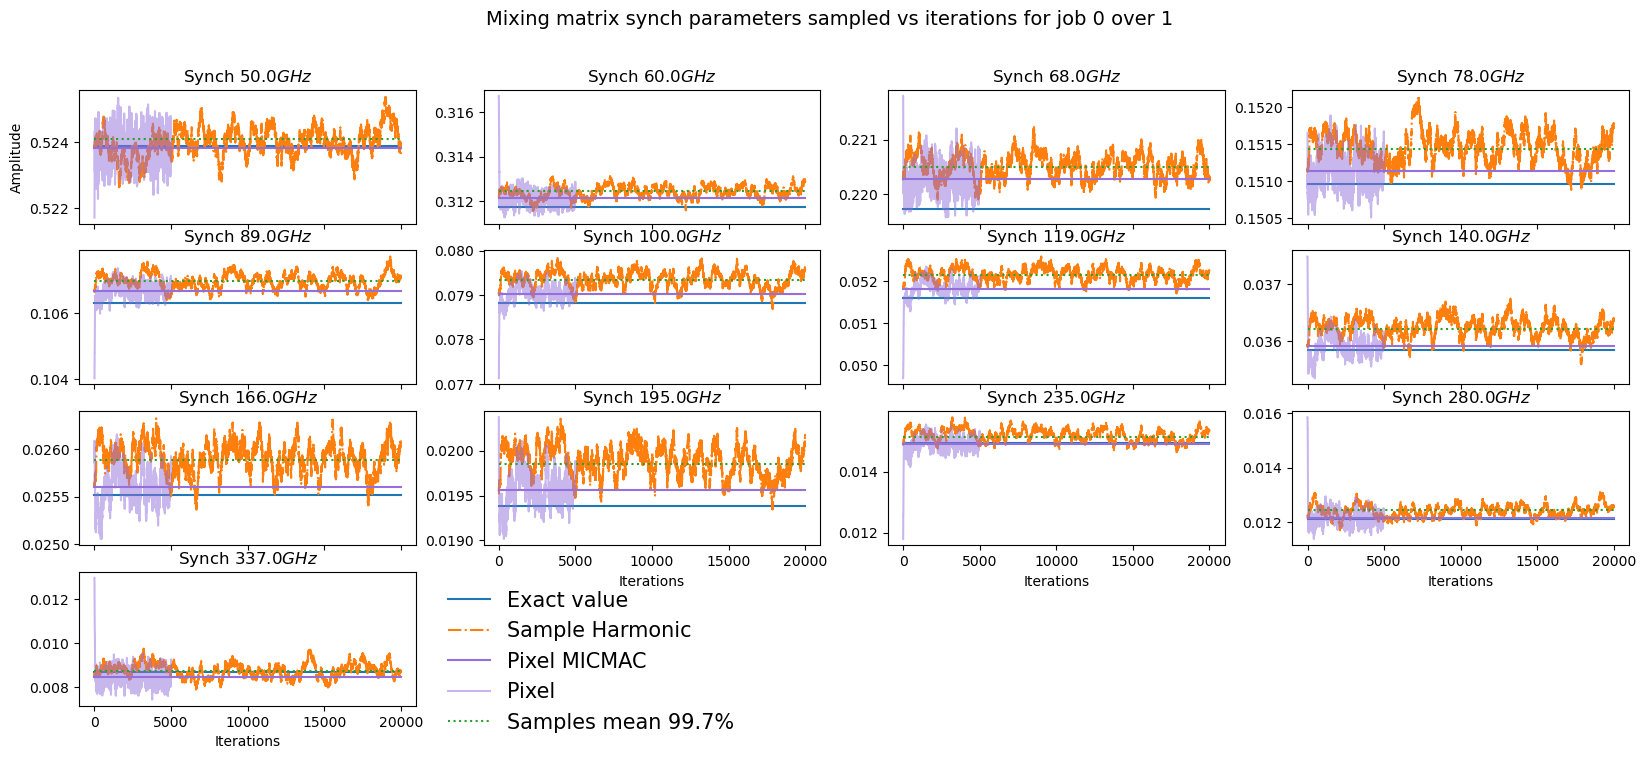

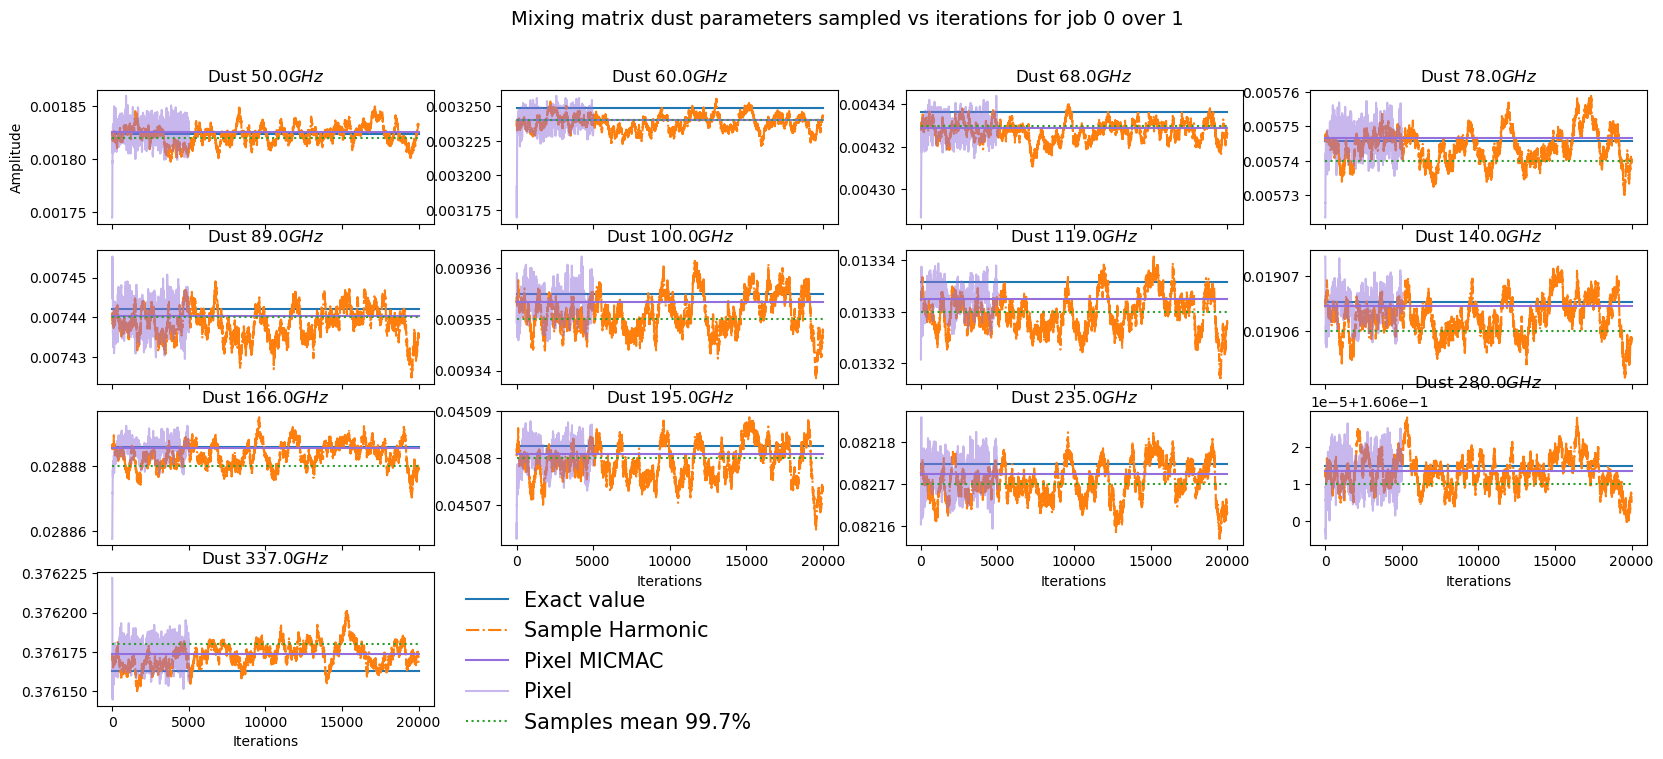

In [29]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_Harm_obj.lmin


frequency_Bf = np.array(instrument['frequency'][1:-1])
dimension_free_param_B_f = 2*(MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs)
dim_freq_B_f = len(frequency_Bf)

alpha_value = .5
color_MICMAC_pixel = 'mediumpurple'
color_MICMAC_pixel_list = ['mediumpurple', 'green', 'red', 'gold', 'sienna']



MICMAC_B_f_sample_synch = MICMAC_all_params_mixing_matrix_samples[...,:dim_freq_B_f]
MICMAC_B_f_sample_dust = MICMAC_all_params_mixing_matrix_samples[...,dim_freq_B_f:]
final_MICMAC_pixel_B_f_synch = MICMAC_all_params_mixing_matrix_samples.mean(axis=1)[...,:dim_freq_B_f]
final_MICMAC_pixel_B_f_dust = MICMAC_all_params_mixing_matrix_samples.mean(axis=1)[...,dim_freq_B_f:]

burn_in_iterations = MICMAC_Harm_obj.number_iterations_sampling//2
cond = np.arange(MICMAC_Harm_obj.number_iterations_sampling) > burn_in_iterations

for job in range(num_jobs):
    all_B_f_sample_synch = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,:dim_freq_B_f]
    all_B_f_sample_dust = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,dim_freq_B_f:]
    
    frequency_array = np.array(instrument['frequency'])


    if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs >= 10:
        number_columns = 4
        number_rows = (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)//number_columns + 1

        # plt.figure(figsize=(20,8))
        fig, ax = plt.subplots(number_rows, number_columns, figsize=(20,8))
        useless_plots = number_rows*number_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*number_columns)//number_columns
            num_col = (number_rows*number_columns)%number_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

        fig.suptitle(f"Mixing matrix synch parameters sampled vs iterations for job {job} over {num_jobs}", fontsize=14)
        # plt.subplot(121)

        for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            # plt.subplot(201+len(frequency_Bf)*10+i)
            num_row = i//number_columns
            num_col = i%number_columns
            ax[num_row, num_col].set_title((f'Synch ${frequency_Bf[i]} GHz$'))
            # plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
            
            ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [init_params[i],init_params[i]], label='Exact value')
            ax[num_row, num_col].plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_B_f_sample_synch[:,i], '-.', label='Sample Harmonic')

            ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_synch[0,i],final_MICMAC_pixel_B_f_synch[0,i]], color=color_MICMAC_pixel, label='Pixel MICMAC')
            ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_synch[0,:,i], color=color_MICMAC_pixel_list[0], alpha=alpha_value, label='Pixel')
            for j in range(1,MICMAC_B_f_sample_synch.shape[0]):
                ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_synch[j,:,i], color=color_MICMAC_pixel_list[j], alpha=alpha_value)
                ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_synch[j,i],final_MICMAC_pixel_B_f_synch[j,i]], color=color_MICMAC_pixel)
        
            # n_sigma = 3
            # transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
            # cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
            mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
            std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

            mean_value = all_B_f_sample_synch[:,i].mean()
            ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

            # plt.yscale('log')
            # plt.xlabel('Iterations')
            # ax[num_row, num_col].set_xlabel('Iterations')
            if i == 0:
                # plt.ylabel('Amplitude')
                ax[num_row, num_col].set_ylabel('Amplitude')
            if i >= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-number_columns:
                ax[num_row, num_col].set_xlabel('Iterations')
            else:
                ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

        # plt.figure(figsize=(20,8))
        # plt.subplot(122)
        fig, ax = plt.subplots(number_rows, number_columns, figsize=(20,8))
        useless_plots = number_rows*number_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*number_columns)//number_columns
            num_col = (number_rows*number_columns)%number_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])


        fig.suptitle(f"Mixing matrix dust parameters sampled vs iterations for job {job} over {num_jobs}", fontsize=14)
        
        for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            # plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
            # plt.subplot(201+len(frequency_Bf)*10+i)
            num_row = i//number_columns
            num_col = i%number_columns
            ax[num_row, num_col].set_title((f'Dust ${frequency_Bf[i]} GHz$'))
            ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [init_params[i+dimension_free_param_B_f//2],init_params[i+dimension_free_param_B_f//2]], label='Exact value')
            ax[num_row, num_col].plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_B_f_sample_dust[:,i], '-.', label='Sample Harmonic')

            ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_dust[0,i],final_MICMAC_pixel_B_f_dust[0,i]], color=color_MICMAC_pixel, label='Pixel MICMAC')
            ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_dust[0,:,i], color=color_MICMAC_pixel_list[0], alpha=alpha_value,label='Pixel')
            for j in range(1,MICMAC_B_f_sample_dust.shape[0]):
                ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_dust[j,:,i], color=color_MICMAC_pixel_list[j], alpha=alpha_value)
                ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_dust[j,i],final_MICMAC_pixel_B_f_dust[j,i]], color=color_MICMAC_pixel)

            # n_sigma = 3
            # transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
            # cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
            mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
            std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

            mean_value = all_B_f_sample_dust[:,i].mean()
            ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
            # plt.yscale('log')
            
            if i == 0:
                ax[num_row, num_col].set_ylabel('Amplitude')
            if i >= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-number_columns:
                ax[num_row, num_col].set_xlabel('Iterations')
            else:
                ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

    plt.show()

In [30]:
expected_burn_in = 5

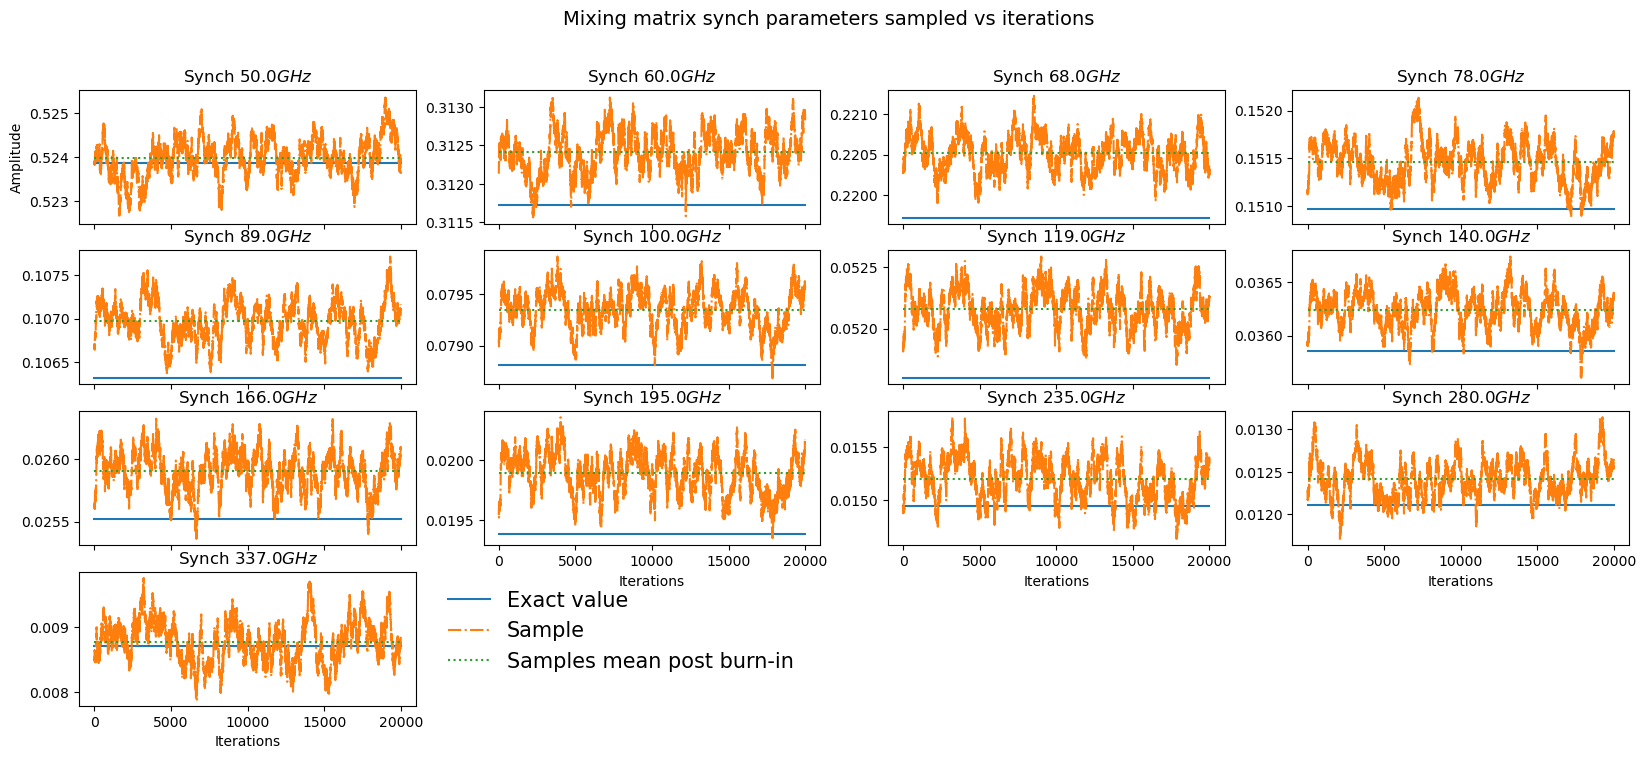

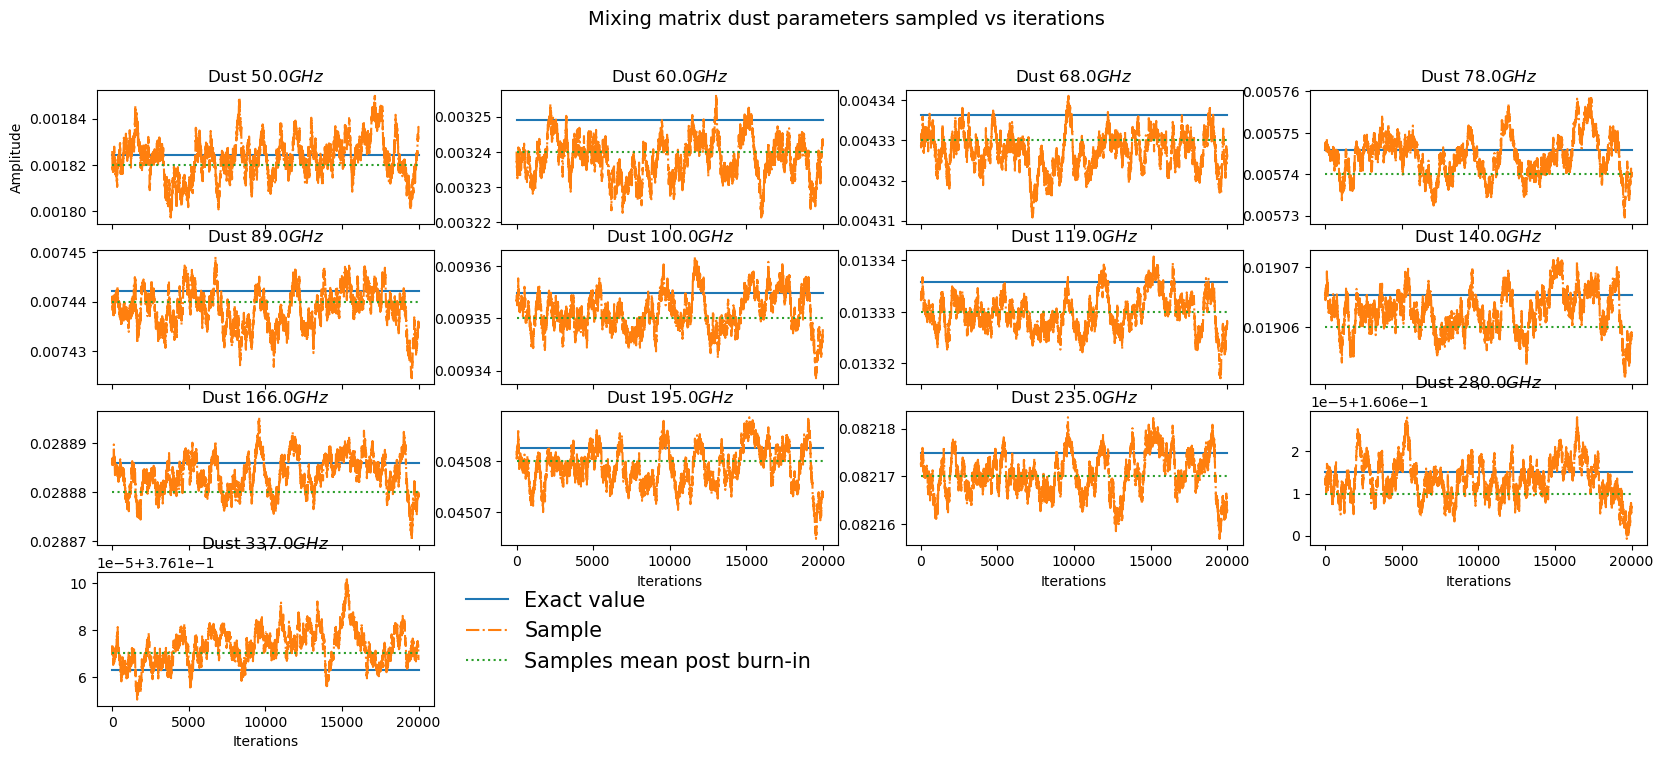

In [31]:
list_correl = ['EE', 'BB', 'EB']

red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)
ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_Harm_obj.lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
dim_Bf = len(frequency_Bf)
dim_synch = MICMAC_Harm_obj.indexes_b[0,1]
len_pos_special_freqs = len(MICMAC_Harm_obj.pos_special_freqs)


all_B_f_sample_synch = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,:dim_synch]
all_B_f_sample_dust = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,dim_synch:]

frequency_array = np.array(instrument['frequency'])

n_columns = 4
number_rows = (MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs)//n_columns + 1

fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
useless_plots = number_rows*n_columns - (MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs)
for idx_useless in range(0,useless_plots):
    num_row = (number_rows*n_columns)//n_columns
    num_col = (number_rows*n_columns)%n_columns
    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

fig.suptitle(f"Mixing matrix synch parameters sampled vs iterations", fontsize=14)

for i in range(MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs):
    num_row = i//n_columns
    num_col = i%n_columns
    ax[num_row, num_col].set_title((f'Synch ${frequency_Bf[i]} GHz$'))
    
    ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling+1], [init_params[i],init_params[i]], label='Exact value')
    ax[num_row, num_col].plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_B_f_sample_synch[:,i], '-.', label='Sample')

    cond = np.where(np.arange(MICMAC_Harm_obj.number_iterations_sampling+1) > expected_burn_in)[0]
    mean_B_f = np.round(all_B_f_sample_synch[cond,i][cond].mean(), decimals=5)
    std_B_f = np.round(all_B_f_sample_synch[cond,i][cond].std(), decimals=5)

    mean_value = all_B_f_sample_synch[:,i].mean()
    ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean post burn-in')

    if i == 0:
        ax[num_row, num_col].set_ylabel('Amplitude')
    if i >= MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs-n_columns:
        ax[num_row, num_col].set_xlabel('Iterations')
    else:
        ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
useless_plots = number_rows*n_columns - (MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs)
for idx_useless in range(0,useless_plots):
    num_row = (number_rows*n_columns)//n_columns
    num_col = (number_rows*n_columns)%n_columns
    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

fig.suptitle(f"Mixing matrix dust parameters sampled vs iterations", fontsize=14)    
for i in range(MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs):
    num_row = i//n_columns
    num_col = i%n_columns
    ax[num_row, num_col].set_title((f'Dust ${frequency_Bf[i]} GHz$'))
    ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling+1], [init_params[i+dim_synch],init_params[i+dim_synch]], label='Exact value')
    ax[num_row, num_col].plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_B_f_sample_dust[:,i], '-.', label='Sample')

    cond = np.where(np.arange(MICMAC_Harm_obj.number_iterations_sampling+1) > expected_burn_in)[0]
    mean_B_f = np.round(all_B_f_sample_dust[cond,i].mean(), decimals=5)
    std_B_f = np.round(all_B_f_sample_dust[cond,i].std(), decimals=5)

    mean_value = all_B_f_sample_dust[:,i].mean()
    ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean post burn-in')
    if i == 0:
        ax[num_row, num_col].set_ylabel('Amplitude')
    if i >= MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs-n_columns:
        ax[num_row, num_col].set_xlabel('Iterations')
    else:
        ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
plt.show()

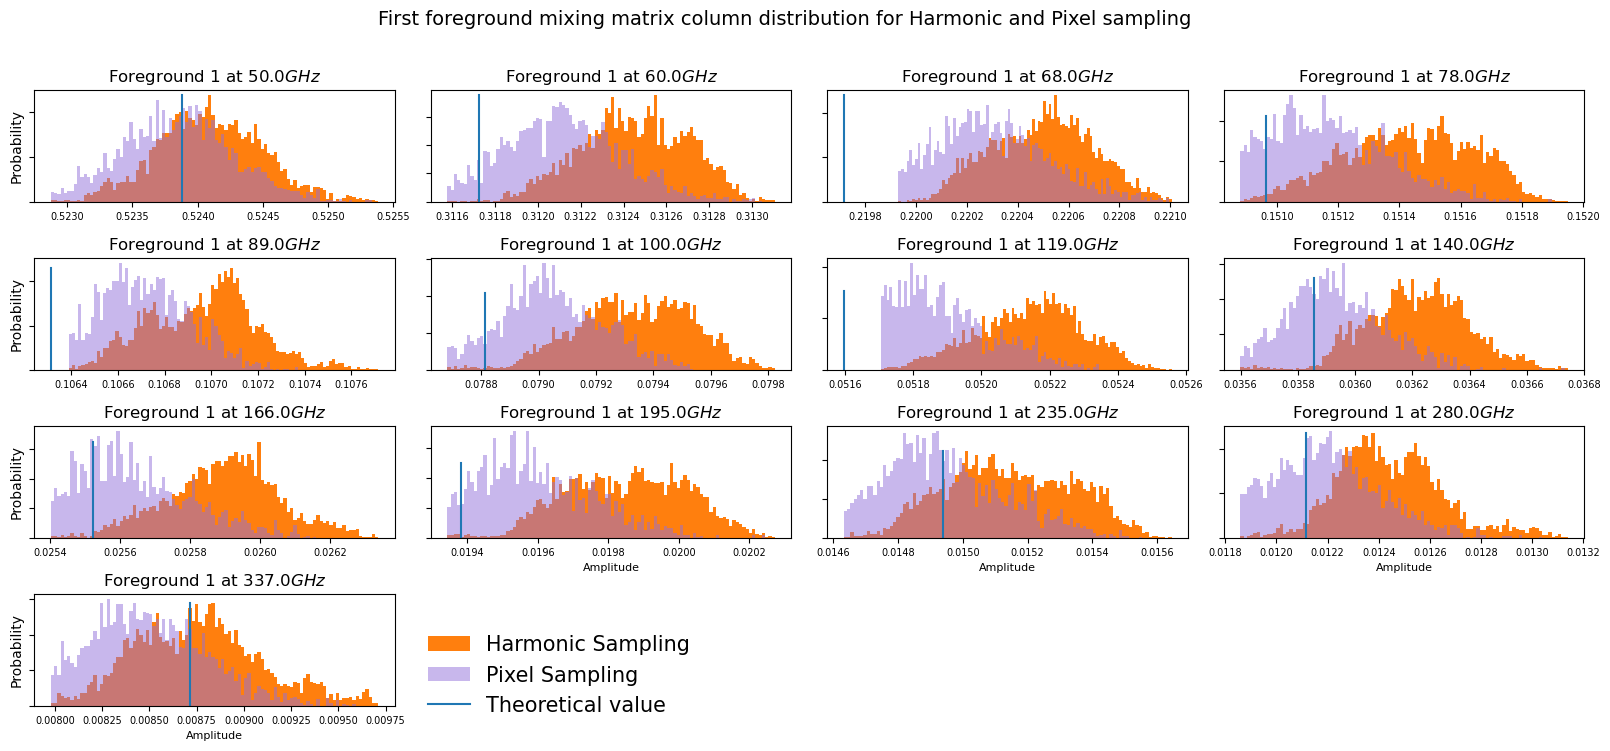

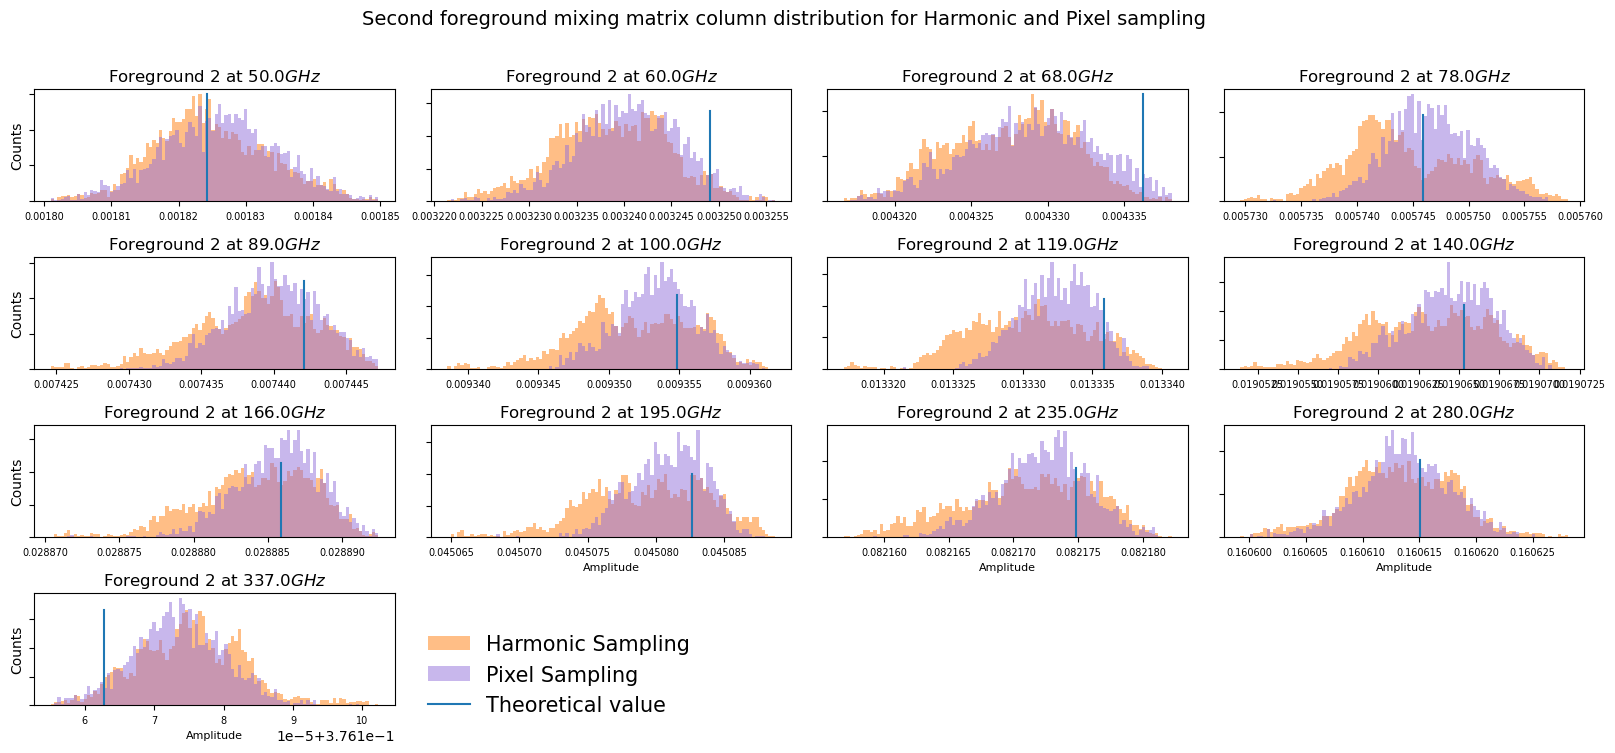

In [72]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_Harm_obj.lmin


frequency_Bf = np.array(instrument['frequency'][1:-1])
dimension_free_param_B_f = 2*(MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs)
dim_freq_B_f = len(frequency_Bf)

alpha_value = .5
color_MICMAC_pixel = 'mediumpurple'
color_MICMAC_pixel_list = ['mediumpurple', 'green', 'red', 'gold', 'sienna']
Harm_color = ['tab:orange']

burn_in = -10000

bins_number = 100

MICMAC_B_f_sample_synch = MICMAC_all_params_mixing_matrix_samples[...,:dim_freq_B_f]
MICMAC_B_f_sample_dust = MICMAC_all_params_mixing_matrix_samples[...,dim_freq_B_f:]
final_MICMAC_pixel_B_f_synch = MICMAC_all_params_mixing_matrix_samples.mean(axis=1)[...,:dim_freq_B_f]
final_MICMAC_pixel_B_f_dust = MICMAC_all_params_mixing_matrix_samples.mean(axis=1)[...,dim_freq_B_f:]

burn_in_iterations = MICMAC_Harm_obj.number_iterations_sampling//2
cond = np.arange(MICMAC_Harm_obj.number_iterations_sampling) > burn_in_iterations

for job in range(num_jobs):
    all_B_f_sample_synch = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,:dim_freq_B_f]
    all_B_f_sample_dust = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,dim_freq_B_f:]
    
    frequency_array = np.array(instrument['frequency'])


    if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs >= 10:
        number_columns = 4
        number_rows = (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)//number_columns + 1

        # plt.figure(figsize=(20,8))
        fig, ax = plt.subplots(number_rows, number_columns, figsize=(20,8))
        plt.subplots_adjust(hspace=.5, wspace=.1)
        useless_plots = number_rows*number_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*number_columns)//number_columns
            num_col = (number_rows*number_columns)%number_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

        fig.suptitle(f"First foreground mixing matrix column distribution for Harmonic and Pixel sampling", fontsize=14)
        # plt.subplot(121)

        for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            # plt.subplot(201+len(frequency_Bf)*10+i)
            num_row = i//number_columns
            num_col = i%number_columns
            ax[num_row, num_col].set_title((f'Foreground 1 at ${frequency_Bf[i]} GHz$'))
            ax[num_row, num_col].xaxis.set_tick_params(labelsize=7)
            
            hist_values, bins_value, _ = ax[num_row, num_col].hist(all_B_f_sample_synch[burn_in:,i], bins=bins_number, density=True, color=Harm_color[0], label='Harmonic Sampling')
            ax[num_row, num_col].hist(MICMAC_B_f_sample_synch[0,burn_in:,i], bins=bins_value, color=color_MICMAC_pixel_list[0], density=True, alpha=alpha_value, label='Pixel Sampling')
            ax[num_row, num_col].plot([init_params[i],init_params[i]], [0,hist_values.max()], label='Theoretical value')

            if num_col == 0:
                ax[num_row, num_col].set_ylabel('Probability')
            ax[num_row, num_col].tick_params(axis='y', labelleft=False)
            if i>= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-number_columns:
                ax[num_row, num_col].set_xlabel('Amplitude', fontsize=8)
            # ax[num_row, num_col].set_xlabel('Amplitude', fontsize=8)
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 0.8), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

        # plt.figure(figsize=(20,8))
        # plt.subplot(122)
        fig, ax = plt.subplots(number_rows, number_columns, figsize=(20,8))
        plt.subplots_adjust(hspace=.5, wspace=.1)
        useless_plots = number_rows*number_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*number_columns)//number_columns
            num_col = (number_rows*number_columns)%number_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])


        fig.suptitle(f"Second foreground mixing matrix column distribution for Harmonic and Pixel sampling", fontsize=14)
        
        for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            # plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
            # plt.subplot(201+len(frequency_Bf)*10+i)
            num_row = i//number_columns
            num_col = i%number_columns
            ax[num_row, num_col].set_title((f'Foreground 2 at ${frequency_Bf[i]} GHz$'))
            ax[num_row, num_col].xaxis.set_tick_params(labelsize=7)

            hist_values, bins_value, _ = ax[num_row, num_col].hist(all_B_f_sample_dust[burn_in:,i], bins=bins_number, density=True, color=Harm_color[0], alpha=alpha_value, label='Harmonic Sampling')
            ax[num_row, num_col].hist(MICMAC_B_f_sample_dust[0,burn_in:,i], bins=bins_value, density=True, color=color_MICMAC_pixel_list[0], alpha=alpha_value, label='Pixel Sampling')
            ax[num_row, num_col].plot([init_params[i+dimension_free_param_B_f//2],init_params[i+dimension_free_param_B_f//2]], [0,hist_values.max()], label='Theoretical value')
            
            if num_col == 0:
                ax[num_row, num_col].set_ylabel('Counts')
            ax[num_row, num_col].tick_params(axis='y', labelleft=False)

            if i>= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-number_columns:
                ax[num_row, num_col].set_xlabel('Amplitude', fontsize=8)
            # ax[num_row, num_col].set_xlabel('Amplitude', fontsize=8)
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 0.8), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

    plt.show()

In [132]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_Harm_obj.lmin


frequency_Bf = np.array(instrument['frequency'][1:-1])
dimension_free_param_B_f = 2*(MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs)
dim_freq_B_f = len(frequency_Bf)

alpha_value = .5
color_MICMAC_pixel = 'mediumpurple'
color_MICMAC_pixel_list = ['mediumpurple', 'green', 'red', 'gold', 'sienna']
Harm_color = ['tab:orange']

burn_in = -10000

bins_number = 100

MICMAC_B_f_sample_synch = MICMAC_all_params_mixing_matrix_samples[...,:dim_freq_B_f]
MICMAC_B_f_sample_dust = MICMAC_all_params_mixing_matrix_samples[...,dim_freq_B_f:]
final_MICMAC_pixel_B_f_synch = MICMAC_all_params_mixing_matrix_samples.mean(axis=1)[...,:dim_freq_B_f]
final_MICMAC_pixel_B_f_dust = MICMAC_all_params_mixing_matrix_samples.mean(axis=1)[...,dim_freq_B_f:]

burn_in_iterations = MICMAC_Harm_obj.number_iterations_sampling//2
cond = np.arange(MICMAC_Harm_obj.number_iterations_sampling) > burn_in_iterations

job = 0
all_B_f_sample_synch = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,:dim_freq_B_f]
all_B_f_sample_dust = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,dim_freq_B_f:]

frequency_array = np.array(instrument['frequency'])

# names = [f"B_f^{i}" for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)]
names_B_f1 = ['$B{}$'.format('_{f1}^{'+str(i)+'}') for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)]
if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs >= 10:
    number_columns = 4
    number_rows = (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)//number_columns + 1

    samples_synch_Harm = MCSamples(samples=all_B_f_sample_synch, names=names_B_f1, label='Harmonic Sampling')
    samples_synch_Pixel = MCSamples(samples=MICMAC_B_f_sample_synch, names=names_B_f1, label='Pixel Sampling')
    # plt.figure(figsize=(20,8))
    # fig, ax = plt.subplots(number_rows, number_columns, figsize=(20,8))

    
    g_fg1 = plots.get_subplot_plotter()
    plt.suptitle(f"First foreground mixing matrix column distribution for Harmonic and Pixel sampling", fontsize=14)

    # g_fg1.make_figure(nplot=(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)*(MICMAC_sampler_obj.n_components-1),
    #                  nx=number_rows, ny=number_columns, xstretch=1.5, ystretch=1.5)

    g_fg1.plots_1d([samples_synch_Harm, samples_synch_Pixel], 
                   names_B_f1,
                   nx=number_rows, ny=number_columns,
                   colors='Set1', 
                   ls=['-','--'])
    # plt.subplots_adjust(hspace=.5, wspace=.1) 

    
    # plt.suptitle(f"First foreground mixing matrix column distribution for Harmonic and Pixel sampling", fontsize=14)
    # g_fg1.set_title((f'Foreground 1 at ${frequency_Bf[i]} GHz$'))
    # plt.subplot(121)

    # for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
    #     # plt.subplot(201+len(frequency_Bf)*10+i)
    #     num_row = i//number_columns
    #     num_col = i%number_columns
    #     ax[num_row, num_col].set_title((f'Foreground 1 at ${frequency_Bf[i]} GHz$'))
    #     ax[num_row, num_col].xaxis.set_tick_params(labelsize=7)
        
    #     hist_values, bins_value, _ = ax[num_row, num_col].hist(all_B_f_sample_synch[burn_in:,i], bins=bins_number, density=True, color=Harm_color[0], label='Harmonic Sampling')
    #     ax[num_row, num_col].hist(MICMAC_B_f_sample_synch[0,burn_in:,i], bins=bins_value, color=color_MICMAC_pixel_list[0], density=True, alpha=alpha_value, label='Pixel Sampling')
    #     ax[num_row, num_col].plot([init_params[i],init_params[i]], [0,hist_values.max()], label='Theoretical value')

    #     if num_col == 0:
    #         ax[num_row, num_col].set_ylabel('Probability')
    #     ax[num_row, num_col].tick_params(axis='y', labelleft=False)
    #     if i>= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-number_columns:
    #         ax[num_row, num_col].set_xlabel('Amplitude', fontsize=8)
    # ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 0.8), loc="upper left", prop={'size': 15}, frameon=False)
    plt.show()

Removed no burn in
Removed no burn in


AttributeError: module 'getdist.plots' has no attribute 'suptitle'

(9999,) 20000


/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


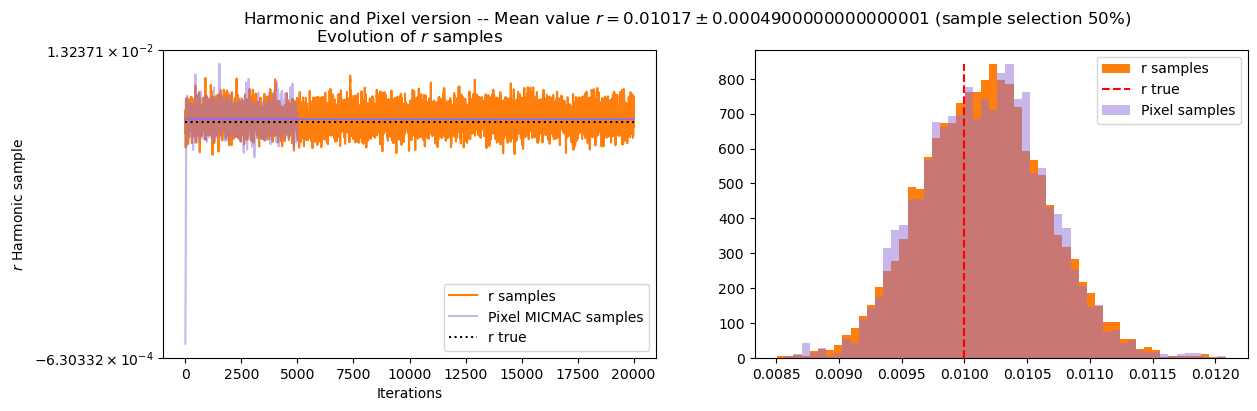

In [32]:
plt.figure(figsize=(14,4))

# n_sigma = 3

all_r_samples = MICMAC_Harm_obj.all_samples_r

burn_in_iterations = MICMAC_Harm_obj.number_iterations_sampling//2
# cond = np.abs((all_r_samples - all_r_samples.mean())/(all_r_samples.std())) < n_sigma
cond = np.arange(MICMAC_Harm_obj.number_iterations_sampling) > burn_in_iterations
print(all_r_samples[cond].shape, MICMAC_Harm_obj.number_iterations_sampling)
mean_r = np.round(all_r_samples[cond].mean(), decimals=5)
std_r = np.round(all_r_samples[cond].std(), decimals=5)

alpha_value = .5
color_MICMAC_pixel = 'mediumpurple'
color_MICMAC_pixel_list = ['mediumpurple', 'blue', 'red', 'gold', 'brown']

plt.suptitle(f"Harmonic and Pixel version -- Mean value $r = {mean_r} \pm {std_r}$ (sample selection 50%) ")

final_MICMAC_pixel_r = MICMAC_all_r_samples.mean(axis=1)

plt.subplot(121)
plt.plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_r_samples, color='tab:orange', label='r samples')

plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_all_r_samples[0], color=color_MICMAC_pixel_list[0], label='Pixel MICMAC samples', alpha=alpha_value)
plt.plot([0, MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_r[0],final_MICMAC_pixel_r[0]], color=color_MICMAC_pixel)
for i in range(1,MICMAC_all_r_samples.shape[0]):
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_all_r_samples[i], color=color_MICMAC_pixel_list[i], alpha=alpha_value)

    plt.plot([0, MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_r[i],final_MICMAC_pixel_r[i]], color=color_MICMAC_pixel)

plt.plot([0, MICMAC_Harm_obj.number_iterations_sampling], [MICMAC_Harm_obj.r_true,MICMAC_Harm_obj.r_true], 'k:', label='r true')


plt.xlabel("Iterations")
plt.ylabel('$r$ Harmonic sample')
plt.title(r'Evolution of $r$ samples')
if MICMAC_Harm_obj.r_true > 0:
    plt.yscale('symlog')
else:
    plt.yscale('log')
plt.legend()

plt.subplot(122)
hist_values, bins_value, _ = plt.hist(all_r_samples, bins='rice', label='r samples', color='tab:orange', density=True)
plt.plot([MICMAC_Harm_obj.r_true,MICMAC_Harm_obj.r_true], [0,hist_values.max()], 'r--', label='r true')
for job in range(num_jobs):
    _, _, _ = plt.hist(MICMAC_all_r_samples[job], bins=bins_value, color=color_MICMAC_pixel_list[job], alpha=alpha_value, density=True, label='Pixel samples')
# plt.plot([final_MICMAC_pixel_r[0],final_MICMAC_pixel_r[0]], [0,hist_values.max()], color=color_MICMAC_pixel, label='Pixel')
# for i in range(1, MICMAC_all_r_samples.shape[0]):
#     plt.plot([final_MICMAC_pixel_r[i],final_MICMAC_pixel_r[i]], [0,hist_values.max()], color=color_MICMAC_pixel)
    
plt.legend()
plt.show()

In [41]:
if save_chains:
    print("Saving chains Harm !!!!!")
    initial_freq_maps_path = directory_save_file+file_ver.format('Harm', MICMAC_Harm_obj.number_iterations_sampling)+"_initial_data.npy"
    print("Saving Harmonic input freq maps in ", initial_freq_maps_path)
    np.save(initial_freq_maps_path, input_freq_maps)

    initial_cmb_maps_path = directory_save_file+file_ver.format('Harm', MICMAC_Harm_obj.number_iterations_sampling)+"_initial_cmb_data.npy"
    print("Saving Harmonic input cmb maps in ", initial_cmb_maps_path)
    np.save(initial_cmb_maps_path, input_cmb_maps)

    all_r_samples_path = directory_save_file+file_ver.format('Harm', MICMAC_Harm_obj.number_iterations_sampling)+"_all_r_samples.npy"
    print("Saving Harmonic r samples in ", all_r_samples_path)
    np.save(all_r_samples_path, MICMAC_Harm_obj.all_samples_r)

    all_params_mixing_matrix_samples_path = directory_save_file+file_ver.format('Harm', MICMAC_Harm_obj.number_iterations_sampling)+"_all_params_mixing_matrix_samples.npy"
    print("Saving Harmonic params mixing matrix in ", all_params_mixing_matrix_samples_path)
    np.save(all_params_mixing_matrix_samples_path, MICMAC_Harm_obj.all_params_mixing_matrix_samples)


Saving chains Harm !!!!!
Saving Harmonic input freq maps in  /Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Paper_runs/save_directory/corr_fullsky_LB_d0s0_nside0_v109_v1a_Harm_20000_initial_data.npy
Saving Harmonic input cmb maps in  /Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Paper_runs/save_directory/corr_fullsky_LB_d0s0_nside0_v109_v1a_Harm_20000_initial_cmb_data.npy
Saving Harmonic r samples in  /Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Paper_runs/save_directory/corr_fullsky_LB_d0s0_nside0_v109_v1a_Harm_20000_all_r_samples.npy
Saving Harmonic params mixing matrix in  /Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Paper_runs/save_directory/corr_fullsky_LB_d0s0_nside0_v109_v1a_Harm_20000_all_params_mixing_matrix_samples.npy


In [34]:
(jnp.sum(all_r_samples*all_r_samples) - all_r_samples.shape[0]*(all_r_samples.mean())**2)/(all_r_samples.shape[0]-1)

Array(2.40645429e-07, dtype=float64)

In [35]:
MICMAC_Harm_obj.all_params_mixing_matrix_samples.shape

(20000, 26)

In [36]:
all_samples_B_f_r = np.zeros((MICMAC_Harm_obj.number_iterations_sampling, (MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs)*2+1))

all_samples_B_f_r[:,-1] = all_r_samples
all_samples_B_f_r[:,:-1] = MICMAC_Harm_obj.all_params_mixing_matrix_samples.reshape((MICMAC_Harm_obj.number_iterations_sampling, (MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs)*2))

In [37]:
jnp.cov(all_samples_B_f_r, rowvar=False) - jnp.cov(all_samples_B_f_r.T)

Array([[ 0.00000000e+00,  0.00000000e+00,  1.65436123e-23,
         5.79026429e-24,  1.32348898e-23, -4.96308368e-24,
         3.30872245e-24, -5.79026429e-24,  7.44462551e-24,
         8.27180613e-24,  2.06795153e-24,  1.65436123e-23,
         1.32348898e-23, -8.27180613e-25, -1.03397577e-25,
         2.32644547e-25,  1.03397577e-25, -5.16987883e-26,
        -1.09859925e-25,  1.22784622e-25, -1.16322274e-25,
         3.10192730e-25,  1.89831488e-25,  0.00000000e+00,
        -2.06795153e-25,  2.06795153e-25, -2.48154184e-24],
       [ 0.00000000e+00,  0.00000000e+00, -6.61744490e-24,
         3.30872245e-24,  0.00000000e+00, -6.61744490e-24,
         0.00000000e+00,  0.00000000e+00, -3.30872245e-24,
         0.00000000e+00,  0.00000000e+00, -6.61744490e-24,
         0.00000000e+00,  3.10192730e-25,  2.06795153e-25,
        -1.55096365e-25, -1.03397577e-25,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -6.46234854e-26,
         0.00000000e+00,  0.00000000e+00,  1.29246971e-

In [38]:
np.diag(sp.linalg.sqrtm(jnp.cov(all_samples_B_f_r.T)))

array([4.30654987e-04, 2.53651140e-04, 1.88370236e-04, 1.78209691e-04,
       1.76981557e-04, 1.18870073e-04, 9.08554777e-05, 1.06306482e-04,
       1.02154243e-04, 1.11529518e-04, 1.52440937e-04, 1.91299914e-04,
       3.09996901e-04, 7.25657937e-06, 4.20631802e-06, 2.99539483e-06,
       2.82418338e-06, 2.31377732e-06, 1.74745489e-06, 1.69836801e-06,
       1.53691744e-06, 1.78284558e-06, 1.90644560e-06, 2.35096870e-06,
       3.01103471e-06, 5.10279925e-06, 4.90336997e-04])

In [39]:
np.diag(sp.linalg.sqrtm(np.linalg.pinv(np.loadtxt(path_Fisher))))

array([4.28701253e-04, 2.77690762e-04, 2.24924052e-04, 1.74277710e-04,
       1.66693838e-04, 1.22848503e-04, 1.07811079e-04, 1.10864796e-04,
       1.17626249e-04, 1.19358151e-04, 1.64255176e-04, 1.98384900e-04,
       3.20246086e-04, 6.91768577e-06, 4.50162272e-06, 3.66220200e-06,
       2.85633743e-06, 2.74056499e-06, 2.03974797e-06, 1.80163190e-06,
       1.85250897e-06, 1.96142108e-06, 1.98757384e-06, 2.70400892e-06,
       3.24202547e-06, 5.18102813e-06, 4.79709305e-04])